In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import numpy as np
import os, pickle
import matplotlib.pyplot as plt
from scipy.optimize import root_scalar, minimize_scalar
from scipy.ndimage import gaussian_filter
import seaborn as sns
from mpl_toolkits.axes_grid1 import make_axes_locatable
from matplotlib.gridspec import GridSpec

from src.model import intensity, create_connect_mat
from src.theory import rate_fn, rate_fn_neg
from src.sim import sim_lif_perturbation, sim_lif_receptor_perturbation, sim_lif_perturbation_x, sim_lif_pop, create_spike_train, sim_determ_lif_recep
from src.phase_plane import dv, phase_plane_plot

In [3]:
from scripts.prob_decision import *

### Cell Type Params

In [44]:
connect_prob_huang = np.array([[0.01, 0.04, 0.03, 0],
                               [0.03, 0.04, 0.03, 0],
                               [0.03, 0, 0, 0.1],
                               [0.01, 0, 0.1, 0]])

# connect_strengths_huang = np.array([[30, 90, 120, 0],
#                                     [40, 150, 60, 0],
#                                     [27, 0, 0, 10],
#                                     [72, 0, 10, 0]])

post_syn_connect_huang = np.array([[400, 1600, 1200, 0],
                                   [120, 160, 120, 0],
                                   [120, 0, 0, 400],
                                   [20, 0, 200, 0]])
connect_prob_2 = post_syn_connect_huang / post_syn_connect_huang.sum()

# N_huang = np.array([[40, 4, 4, 2]]).T

In [55]:
tcp = connect_prob_2.copy()
#tcp[0,0] = 0.2 # altering?
tcp 

array([[0.0921659 , 0.36866359, 0.2764977 , 0.        ],
       [0.02764977, 0.03686636, 0.02764977, 0.        ],
       [0.02764977, 0.        , 0.        , 0.0921659 ],
       [0.00460829, 0.        , 0.04608295, 0.        ]])

In [6]:
tcp = np.array([[1, 1, 1, 0],
                [1, 1, 1, 0],
                [1, 0, 0, 1],
                [1, 0, 1, 0]])

In [7]:
Npyr = 3200
Npv = 320
Nsst = 320
Nvip = 160

pyr_idx = Npyr
pv_idx = pyr_idx + 320
sst_idx = pv_idx + 320
vip_idx = sst_idx + 160


ct_n = [Npyr, Npv, Nsst, Nvip]
ct_idx = [0, pyr_idx, pv_idx, sst_idx, vip_idx]
ct_names = ["Pyramidal", "PV+", "SST+", "VIP"]

In [38]:
# afferent indices
pvn = 1
sstn = 2
vipn = 3

print(f"Number of inhibitory postsynaptic connections to PV+: {tcp[pvn,1:] @ ct_n[1:]}")
print(f"Number of inhibitory postsynaptic connections to SST+: {tcp[sstn,1:] @ ct_n[1:]}")
print(f"Number of inhibitory postsynaptic connections to VIP: {tcp[vipn,1:] @ ct_n[1:]}")

Number of inhibitory postsynaptic connections to PV+: 20.645161290322584
Number of inhibitory postsynaptic connections to SST+: 14.746543778801843
Number of inhibitory postsynaptic connections to VIP: 14.746543778801843


In [39]:
# from Pfeffer et al. 2013
mut_inh = np.array([[1, 1, 0.54, 0],
                    [1, 1, 0.33, 0],
                    [1, 0, 0, 0.15],
                    [1, 0.22, 0.77, 0]])
#mut_inh[2,3] = 1.8

con_str = tcp * mut_inh
print(f"Postsynaptic inhibitory connection strength to PV+: {con_str[pvn,1:] @ ct_n[1:]}")
print(f"Postsynaptic inhibitory connection strength to SST+: {con_str[sstn,1:] @ ct_n[1:]}")
print(f"Postsynaptic inhibitory connection strength to VIP: {con_str[vipn,1:] @ ct_n[1:]}")

Postsynaptic inhibitory connection strength to PV+: 14.717050691244241
Postsynaptic inhibitory connection strength to SST+: 2.2119815668202767
Postsynaptic inhibitory connection strength to VIP: 11.35483870967742


In [8]:
connect_mat = np.zeros((4000,4000))

for pre in range(1,5): # presynaptic
    for pos in range(1,5): # postsynaptic
        connect_mat[ct_idx[pos-1]:ct_idx[pos], ct_idx[pre-1]:ct_idx[pre]] = np.random.binomial(n=1,
                                                                                               p=tcp[pos-1,pre-1],
                                                                                               size=(ct_n[pos-1],ct_n[pre-1])) #* mut_inh[pos-1,pre-1]

## Simulations

A mean rate: 60.480000000000004 Hz
B mean rate: 19.519999999999996 Hz
Stimulation length: 2 seconds
Simulating network of 2000 neurons


  0%|          | 0/39999 [00:00<?, ?it/s]

Reaction time: 0.17825537294563842 seconds


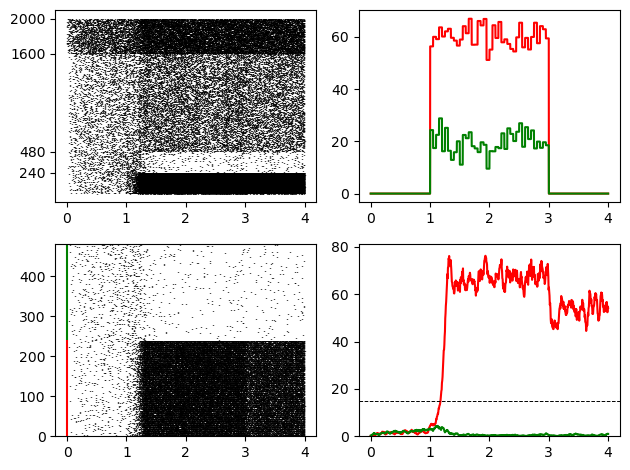

In [11]:
lif_sim,sens_input,firing_rates,reaction_time = produce_prob_decision(mu_0=40, coh=51.2, stim_len=2)

### More cells

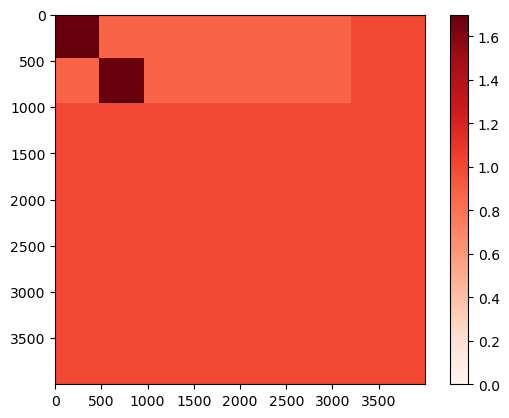

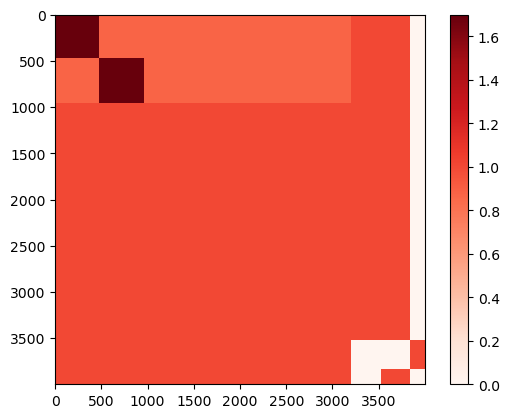

In [9]:
Jmat = create_connect_mat(Ne=3200, Ni=800, f=0.15, wstrong=1.7, plot=True)
Jmat_ct = Jmat * connect_mat
plt.imshow(Jmat_ct, cmap='Reds', interpolation='nearest')
plt.colorbar()

A mean rate: 37.44 Hz
B mean rate: 42.56 Hz
Stimulation length: 2 seconds
Simulating network of 4000 neurons


  0%|          | 0/39999 [00:00<?, ?it/s]

Reaction time: inf seconds


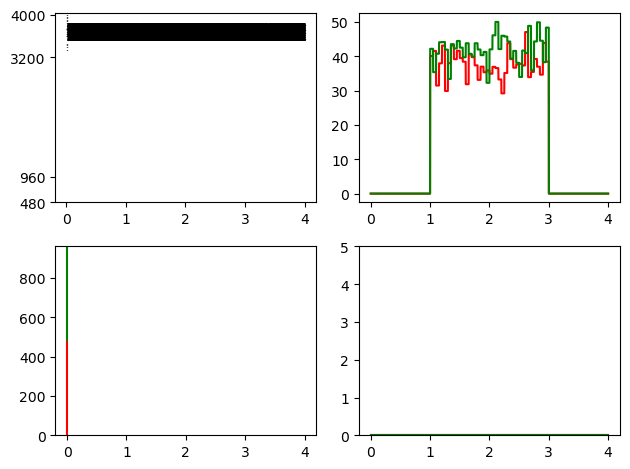

In [10]:
lif_sim,sens_input,firing_rates,reaction_time = produce_prob_decision(mu_0=40, coh=-6.4, Ne=3200, Ni=800, Jmat=Jmat_ct, stim_len=2)

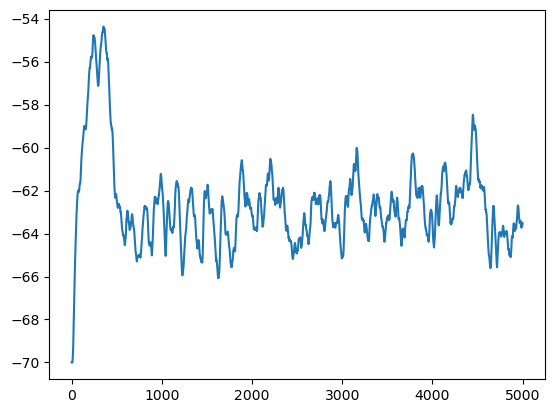

In [41]:
plt.plot(lif_sim['voltage'][:5000,3300]) 
#plt.plot(lif_sim['syn_currents']['gaba'][:5000,5]) # VIP

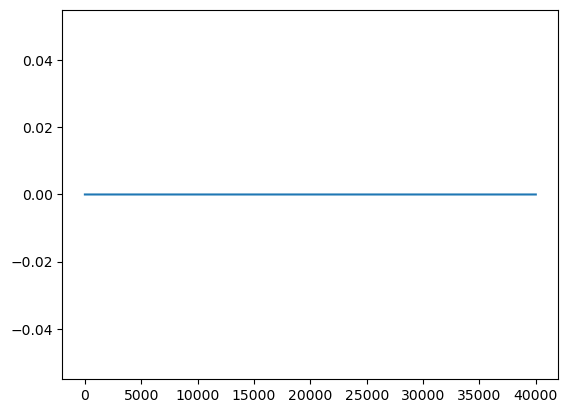

In [ ]:
plt.plot(lif_sim['syn_currents']['gaba'][:,3999]) # VIP

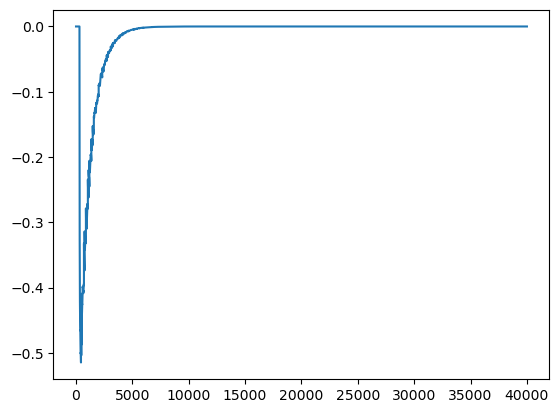

In [33]:
plt.plot(lif_sim['syn_currents']['nmda'][:,3600]) # SST

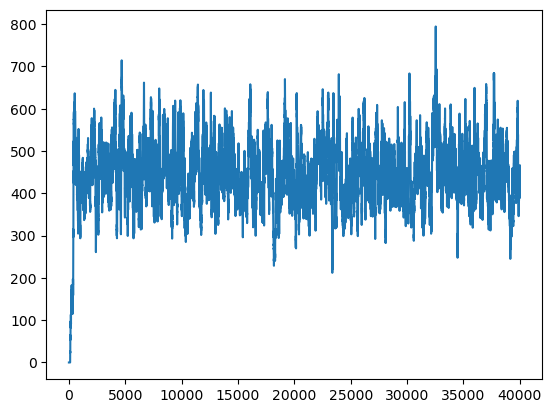

In [28]:
plt.plot(lif_sim['syn_currents']['gaba'][:,3000]) # E pyr